In [1]:
# Cell 4A: imports
import os, gc, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Deep learning (Keras - TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [2]:
# Cell 4B: feature builder (per ticker)

# Candidate feature columns (use what's available)
CANDIDATE_FEATURES = [
    # returns / lags
    "ret_1d", "ret_lag_1", "ret_lag_5", "ret_lag_20",
    # prices/technicals
    "ma_21", "rsi", "bb_width",
    # other engineered
    "hl_spread_pct", "co_move",
    "vol_pct_change", "high_vol_regime",
    # (optional rolling OHLC vol estimators if you created them)
    "gk_vol_roll", "rs_vol_roll", "parkinson_vol_roll",
    # simple rolling vol if present
    "vol_roll_std", "realized_vol"
]

def load_ticker_frame(ticker, data_dir="data/prepared"):
    path = os.path.join(data_dir, f"{ticker}_prepared.csv")
    df = pd.read_csv(path, parse_dates=["date"])
    df = df.sort_values("date").reset_index(drop=True)

    # Ensure returns exist
    if "ret_1d" not in df.columns:
        raise ValueError("ret_1d not found. Please run Phase 2 cells first.")

    # Construct realized_vol_21 (rolling std of returns) if missing
    if "realized_vol_21" not in df.columns:
        df["realized_vol_21"] = (
            df.groupby("Name")["ret_1d"]
              .transform(lambda x: x.rolling(21).std())
        )

    # Define target: next-day realized volatility
    df["target_vol"] = df["realized_vol_21"].shift(-1)

    # Keep only usable feature columns
    feature_cols = [c for c in CANDIDATE_FEATURES if c in df.columns]
    # Add safe fallbacks if nothing from OHLC vol estimators
    if not feature_cols:
        feature_cols = ["ret_1d"]

    # Drop rows with NaNs in features/target (common at the start due to rolling)
    use = df[["date", "Name"] + feature_cols + ["target_vol"]].dropna().reset_index(drop=True)

    X = use[feature_cols].copy()
    y = use["target_vol"].astype(float).copy()
    meta = use[["date","Name"]].copy()

    return X, y, meta, feature_cols


In [3]:
# Cell 4C: time-series split & metric helpers

def ts_train_test_split(X, y, meta, split_ratio=0.8):
    n = len(X)
    cut = int(n * split_ratio)
    X_train, X_test = X.iloc[:cut], X.iloc[cut:]
    y_train, y_test = y.iloc[:cut], y.iloc[cut:]
    meta_train, meta_test = meta.iloc[:cut], meta.iloc[cut:]
    return X_train, X_test, y_train, y_test, meta_train, meta_test

def eval_regression(y_true, y_pred, label=""):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = (np.abs((y_true - y_pred) / (y_true + 1e-12))).mean() * 100.0
    print(f"[{label}] MAE={mae:.6f} | RMSE={rmse:.6f} | MAPE={mape:.2f}%")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}


In [4]:
# Cell 4D: Random Forest pipeline with Grid Search and feature importance

def run_random_forest_for_ticker(ticker, data_dir="data/prepared"):
    print(f"\n===== Random Forest :: {ticker} =====")
    X, y, meta, feature_cols = load_ticker_frame(ticker, data_dir=data_dir)

    # Split (time order preserved)
    X_train, X_test, y_train, y_test, meta_train, meta_test = ts_train_test_split(X, y, meta, split_ratio=0.8)

    # Pipeline (RF doesn't need scaling, but adding pipeline keeps it consistent)
    rf = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )

    # TimeSeriesSplit CV
    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        "n_estimators": [300, 400, 600],
        "max_depth": [None, 8, 12],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    }

    gs = GridSearchCV(
        rf, param_grid, scoring="neg_mean_absolute_error",
        cv=tscv, n_jobs=-1, verbose=0
    )
    gs.fit(X_train, y_train)

    best_rf = gs.best_estimator_
    print("Best Params:", gs.best_params_)

    # Evaluate
    pred_train = best_rf.predict(X_train)
    pred_test  = best_rf.predict(X_test)
    eval_regression(y_train, pred_train, label="RF-Train")
    eval_regression(y_test,  pred_test,  label="RF-Test")

    # Feature importance
    imp = pd.Series(best_rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    print("\nTop Feature Importances:")
    print(imp.head(15))

    # Quick plot (optional)
    plt.figure(figsize=(10,5))
    imp.head(15).plot(kind="bar")
    plt.title(f"RF Feature Importance — {ticker}")
    plt.tight_layout()
    plt.show()

    # Attach outputs for later comparison
    out = pd.DataFrame({
        "date": meta_test["date"].values,
        "ticker": meta_test["Name"].values,
        "y_true": y_test.values,
        "y_pred": pred_test
    })
    return best_rf, out, imp

# Example: run for one ticker first
# best_rf, rf_out, rf_imp = run_random_forest_for_ticker("AAL")


In [5]:
# Cell 4E: LSTM sequence builder

def to_sequences(X_df, y_series, seq_len=30):
    """
    Build rolling sequences of length 'seq_len' from feature matrix and y.
    Returns X_seq: (num_samples, seq_len, num_features), y_seq: (num_samples,)
    """
    X_vals = X_df.values
    y_vals = y_series.values
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X_vals)):
        X_seq.append(X_vals[i-seq_len:i])
        y_seq.append(y_vals[i])
    return np.asarray(X_seq), np.asarray(y_seq)

def scale_fit_transform_train_test(X_train, X_test):
    """
    Scale features with StandardScaler (fit on train only).
    Returns scaled arrays and fitted scaler.
    """
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)
    return X_train_s, X_test_s, scaler


In [6]:
# Cell 4F: LSTM model training

def run_lstm_for_ticker(ticker, data_dir="data/prepared", seq_len=30, lr=1e-3, epochs=50, batch_size=32, dropout=0.2):
    print(f"\n===== LSTM :: {ticker} =====")
    X, y, meta, feature_cols = load_ticker_frame(ticker, data_dir=data_dir)
    X_train, X_test, y_train, y_test, meta_train, meta_test = ts_train_test_split(X, y, meta, split_ratio=0.8)

    # Scale features (very important for neural nets)
    X_train_s, X_test_s, scaler = scale_fit_transform_train_test(X_train, X_test)

    # Build sequences
    Xtr_seq, ytr_seq = to_sequences(pd.DataFrame(X_train_s, columns=X.columns), y_train.reset_index(drop=True), seq_len=seq_len)
    Xte_seq, yte_seq = to_sequences(pd.DataFrame(X_test_s, columns=X.columns),  y_test.reset_index(drop=True),  seq_len=seq_len)

    print(f"Train sequences: {Xtr_seq.shape}, Test sequences: {Xte_seq.shape}")

    # LSTM model
    model = Sequential([
        LSTM(64, input_shape=(seq_len, Xtr_seq.shape[-1]), return_sequences=True),
        Dropout(dropout),
        LSTM(32, return_sequences=False),
        Dropout(dropout),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=lr), loss="mae")  # MAE works well for volatility
    es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
    rlrop = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)

    history = model.fit(
        Xtr_seq, ytr_seq,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es, rlrop],
        verbose=0
    )

    # Predictions (align lengths)
    pred_train = model.predict(Xtr_seq, verbose=0).ravel()
    pred_test  = model.predict(Xte_seq, verbose=0).ravel()

    # Evaluate
    eval_regression(ytr_seq, pred_train, label="LSTM-Train")
    eval_regression(yte_seq,  pred_test,  label="LSTM-Test")

    # Rebuild a meta index for test sequences to attach dates/tickers
    meta_test_seq = meta_test.iloc[seq_len:].reset_index(drop=True)
    out = pd.DataFrame({
        "date": meta_test_seq["date"].values,
        "ticker": meta_test_seq["Name"].values,
        "y_true": yte_seq,
        "y_pred": pred_test
    })

    # Quick plot
    plt.figure(figsize=(12,5))
    plt.plot(out["date"], out["y_true"], label="True")
    plt.plot(out["date"], out["y_pred"], label="Pred")
    plt.title(f"LSTM Forecast vs True — {ticker}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Clean up
    gc.collect()
    return model, out, feature_cols


In [7]:
# Cell 4G: Support Vector Regression (optional baseline)

def run_svr_for_ticker(ticker, data_dir="data/prepared"):
    print(f"\n===== SVR :: {ticker} =====")
    X, y, meta, feature_cols = load_ticker_frame(ticker, data_dir=data_dir)
    X_train, X_test, y_train, y_test, meta_train, meta_test = ts_train_test_split(X, y, meta, split_ratio=0.8)

    # Scale features
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    svr = SVR(kernel="rbf")
    param_grid = {
        "C": [1.0, 10.0, 100.0],
        "epsilon": [0.01, 0.05, 0.1],
        "gamma": ["scale", "auto"]
    }
    tscv = TimeSeriesSplit(n_splits=5)
    gs = GridSearchCV(svr, param_grid, scoring="neg_mean_absolute_error", cv=tscv, n_jobs=-1, verbose=0)
    gs.fit(X_train_s, y_train)
    print("Best Params:", gs.best_params_)

    best_svr = gs.best_estimator_
    pred_train = best_svr.predict(X_train_s)
    pred_test  = best_svr.predict(X_test_s)
    eval_regression(y_train, pred_train, label="SVR-Train")
    eval_regression(y_test,  pred_test,  label="SVR-Test")

    out = pd.DataFrame({
        "date": meta_test["date"].values,
        "ticker": meta_test["Name"].values,
        "y_true": y_test.values,
        "y_pred": pred_test
    })
    return best_svr, out



===== Random Forest :: AAL =====
Best Params: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 600}
[RF-Train] MAE=0.000502 | RMSE=0.000948 | MAPE=2.37%
[RF-Test] MAE=0.000855 | RMSE=0.001213 | MAPE=5.37%

Top Feature Importances:
vol_roll_std          0.905275
realized_vol          0.056978
ret_lag_20            0.015561
ma_21                 0.004086
hl_spread_pct         0.003743
ret_lag_5             0.002647
rsi                   0.002343
bb_width              0.001826
vol_pct_change        0.001483
ret_lag_1             0.001261
parkinson_vol_roll    0.001143
rs_vol_roll           0.001060
gk_vol_roll           0.000924
ret_1d                0.000891
co_move               0.000764
dtype: float64


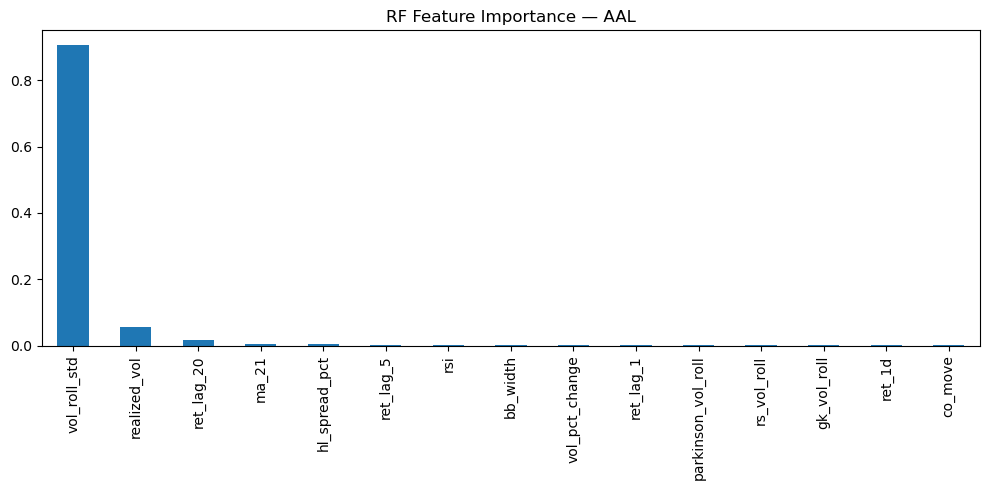


===== LSTM :: AAL =====
Train sequences: (921, 30, 16), Test sequences: (208, 30, 16)

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
[LSTM-Train] MAE=0.002088 | RMSE=0.002824 | MAPE=9.37%
[LSTM-Test] MAE=0.002198 | RMSE=0.002812 | MAPE=13.16%


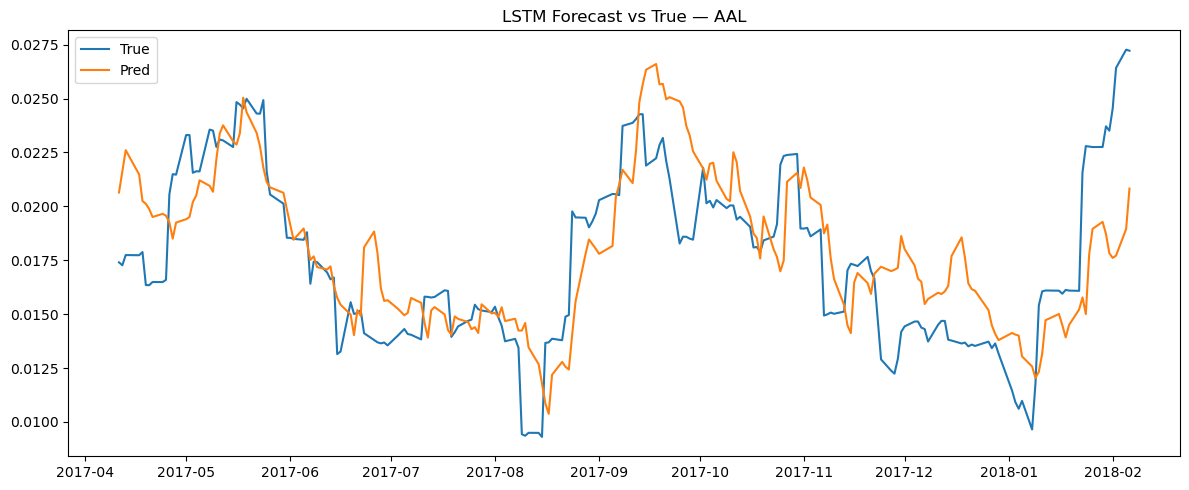


===== SVR :: AAL =====
Best Params: {'C': 1.0, 'epsilon': 0.01, 'gamma': 'scale'}
[SVR-Train] MAE=0.004265 | RMSE=0.004999 | MAPE=21.86%
[SVR-Test] MAE=0.005045 | RMSE=0.005832 | MAPE=33.41%

Sample of merged test results:
        date ticker  y_pred_rf  y_pred_lstm    y_pred    y_true
0 2017-02-28    AAL   0.015377          NaN  0.021266  0.012687
1 2017-03-01    AAL   0.012829          NaN  0.020019  0.014028
2 2017-03-02    AAL   0.014730          NaN  0.021965  0.014755
3 2017-03-03    AAL   0.015898          NaN  0.021413  0.016680
4 2017-03-06    AAL   0.018336          NaN  0.024437  0.016860


In [8]:
# Cell 4H: choose 2–3 representative tickers (from Phase 2.1)
tickers = ["AAL"]  # <- add 1–2 more e.g., ["AAL", "AAPL", "MSFT"]

all_results = []

for t in tickers:
    # Random Forest
    rf_model, rf_out, rf_imp = run_random_forest_for_ticker(t)

    # LSTM
    lstm_model, lstm_out, feats = run_lstm_for_ticker(t, seq_len=30, epochs=40, batch_size=32)

    # SVR (optional)
    svr_model, svr_out = run_svr_for_ticker(t)

    # Collect last models’ test outputs side-by-side (align on date)
    merged = rf_out.merge(lstm_out, on=["date","ticker"], how="outer", suffixes=("_rf", "_lstm"))
    merged = merged.merge(svr_out, on=["date","ticker"], how="outer")
    merged = merged.rename(columns={"y_true_x":"y_true_rf", "y_true_y":"y_true_lstm", "y_true":"y_true_svr"})

    # A single 'y_true' (prefer RF true if available)
    merged["y_true"] = merged["y_true_rf"].combine_first(merged["y_true_lstm"]).combine_first(merged["y_true_svr"])
    merged = merged.drop(columns=["y_true_rf","y_true_lstm","y_true_svr"])
    all_results.append(merged)

# Concatenate all tickers’ results
final_results = pd.concat(all_results, ignore_index=True)

print("\nSample of merged test results:")
print(final_results.head())


In [9]:
# Cell 4H: XGBoost Regressor (optional baseline/ensemble)

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

def run_xgboost_for_ticker(ticker, data_dir="data/prepared"):
    print(f"\n===== XGBoost :: {ticker} =====")
    
    # Load prepared features & target
    X, y, meta, feature_cols = load_ticker_frame(ticker, data_dir=data_dir)
    X_train, X_test, y_train, y_test, meta_train, meta_test = ts_train_test_split(X, y, meta, split_ratio=0.8)
    
    # Scale features
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)
    
    # Define model
    xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
    
    # Hyperparameter grid
    param_grid = {
        "n_estimators": [200, 400, 600],
        "max_depth": [4, 6, 8],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    }
    
    # TimeSeriesSplit for CV
    tscv = TimeSeriesSplit(n_splits=5)
    gs = GridSearchCV(xgb, param_grid, scoring="neg_mean_absolute_error", cv=tscv, n_jobs=-1, verbose=0)
    gs.fit(X_train_s, y_train)
    print("Best Params:", gs.best_params_)
    
    # Best model
    best_xgb = gs.best_estimator_
    pred_train = best_xgb.predict(X_train_s)
    pred_test  = best_xgb.predict(X_test_s)
    
    # Evaluate
    eval_regression(y_train, pred_train, label="XGB-Train")
    eval_regression(y_test,  pred_test,  label="XGB-Test")
    
    # Collect results
    out = pd.DataFrame({
        "date": meta_test["date"].values,
        "ticker": meta_test["Name"].values,
        "y_true": y_test.values,
        "y_pred": pred_test
    })
    
    return best_xgb, out
xgb_model, xgb_out = run_xgboost_for_ticker("AAL")



===== XGBoost :: AAL =====
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 600, 'subsample': 1.0}
[XGB-Train] MAE=0.000495 | RMSE=0.000802 | MAPE=2.37%
[XGB-Test] MAE=0.001224 | RMSE=0.001887 | MAPE=8.20%



>>> Processing ticker AAL ...

===== Random Forest :: AAL =====
Best Params: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 600}
[RF-Train] MAE=0.000502 | RMSE=0.000948 | MAPE=2.37%
[RF-Test] MAE=0.000855 | RMSE=0.001213 | MAPE=5.37%

Top Feature Importances:
vol_roll_std          0.905275
realized_vol          0.056978
ret_lag_20            0.015561
ma_21                 0.004086
hl_spread_pct         0.003743
ret_lag_5             0.002647
rsi                   0.002343
bb_width              0.001826
vol_pct_change        0.001483
ret_lag_1             0.001261
parkinson_vol_roll    0.001143
rs_vol_roll           0.001060
gk_vol_roll           0.000924
ret_1d                0.000891
co_move               0.000764
dtype: float64


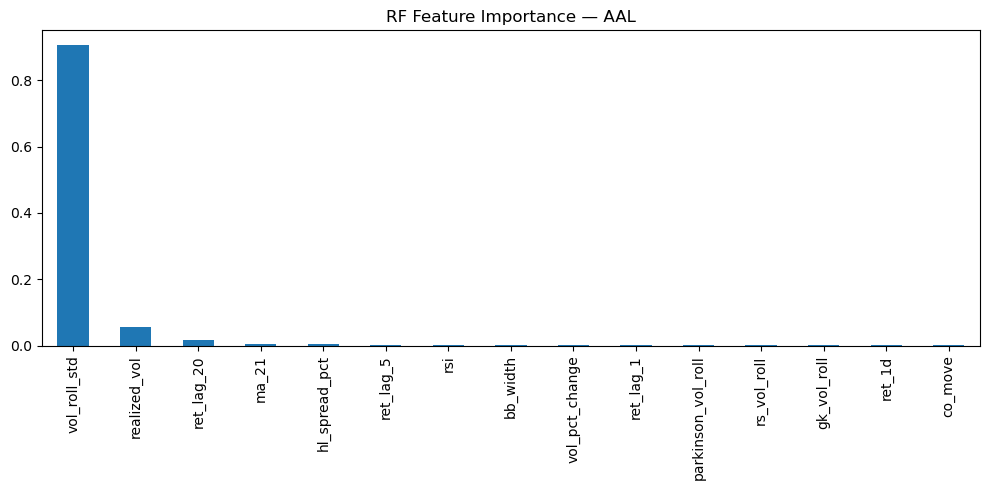

  - rf OK (238 rows)

===== LSTM :: AAL =====
Train sequences: (921, 30, 16), Test sequences: (208, 30, 16)

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 42: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
[LSTM-Train] MAE=0.001781 | RMSE=0.002650 | MAPE=8.02%
[LSTM-Test] MAE=0.001679 | RMSE=0.002208 | MAPE=10.13%


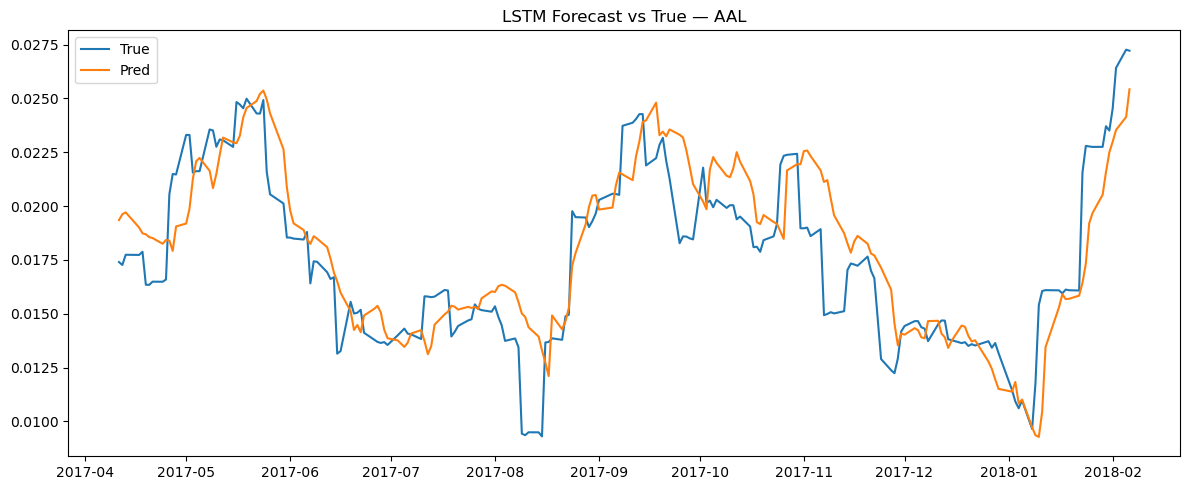

  - lstm OK (208 rows)

===== SVR :: AAL =====
Best Params: {'C': 1.0, 'epsilon': 0.01, 'gamma': 'scale'}
[SVR-Train] MAE=0.004265 | RMSE=0.004999 | MAPE=21.86%
[SVR-Test] MAE=0.005045 | RMSE=0.005832 | MAPE=33.41%
  - svr OK (238 rows)

===== XGBoost :: AAL =====
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 600, 'subsample': 1.0}
[XGB-Train] MAE=0.000495 | RMSE=0.000802 | MAPE=2.37%
[XGB-Test] MAE=0.001224 | RMSE=0.001887 | MAPE=8.20%
  - xgb OK (238 rows)
  - rf metrics: MAE=0.000855, RMSE=0.001213, MAPE=5.37%, DirAcc=56.96%
  - lstm metrics: MAE=0.001679, RMSE=0.002208, MAPE=10.13%, DirAcc=49.76%
  - svr metrics: MAE=0.005045, RMSE=0.005832, MAPE=33.41%, DirAcc=48.52%
  - xgb metrics: MAE=0.001224, RMSE=0.001887, MAPE=8.20%, DirAcc=57.81%

>>> Processing ticker AAPL ...

===== Random Forest :: AAPL =====
Best Params: {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
[RF-Train] MAE=0.000264 | RMSE=0.

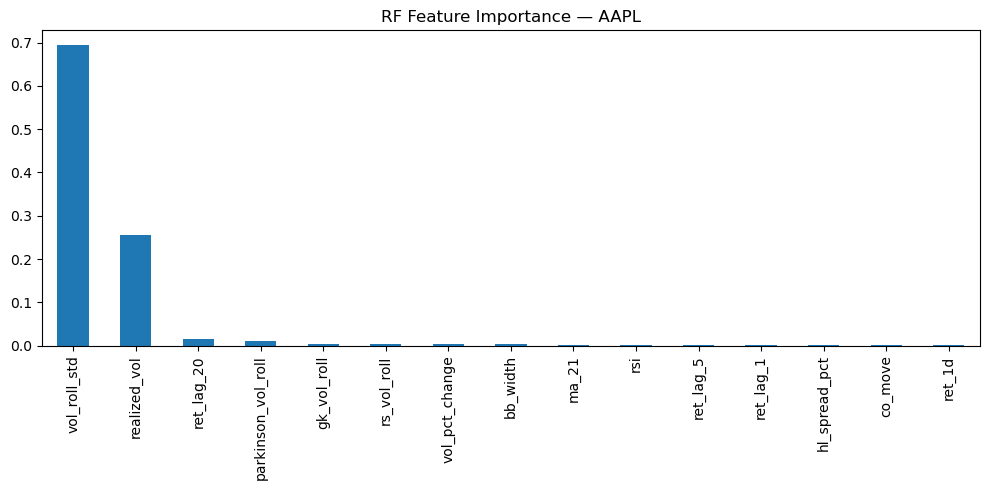

  - rf OK (238 rows)

===== LSTM :: AAPL =====
Train sequences: (921, 30, 16), Test sequences: (208, 30, 16)

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
[LSTM-Train] MAE=0.001410 | RMSE=0.001924 | MAPE=11.00%
[LSTM-Test] MAE=0.001813 | RMSE=0.002433 | MAPE=15.29%


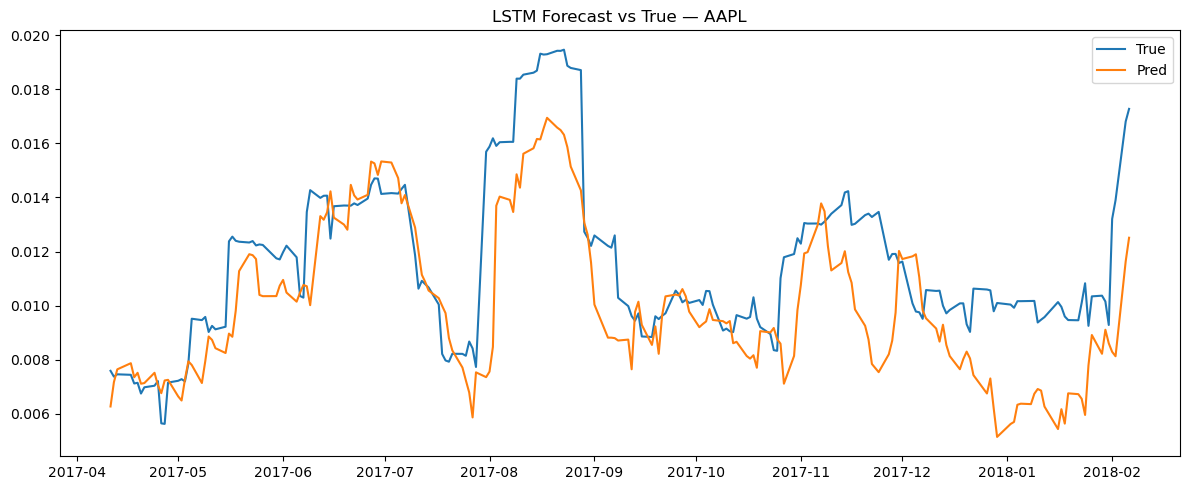

  - lstm OK (208 rows)

===== SVR :: AAPL =====
Best Params: {'C': 1.0, 'epsilon': 0.01, 'gamma': 'auto'}
[SVR-Train] MAE=0.004513 | RMSE=0.005181 | MAPE=40.86%
[SVR-Test] MAE=0.006108 | RMSE=0.006564 | MAPE=67.04%
  - svr OK (238 rows)

===== XGBoost :: AAPL =====
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
[XGB-Train] MAE=0.000283 | RMSE=0.000422 | MAPE=2.18%
[XGB-Test] MAE=0.000698 | RMSE=0.001185 | MAPE=7.86%
  - xgb OK (238 rows)
  - rf metrics: MAE=0.000674, RMSE=0.001096, MAPE=6.91%, DirAcc=54.85%
  - lstm metrics: MAE=0.001813, RMSE=0.002433, MAPE=15.29%, DirAcc=50.24%
  - svr metrics: MAE=0.006108, RMSE=0.006564, MAPE=67.04%, DirAcc=50.63%
  - xgb metrics: MAE=0.000698, RMSE=0.001185, MAPE=7.86%, DirAcc=59.49%

>>> Processing ticker MSFT ...

===== Random Forest :: MSFT =====
Best Params: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 600}
[RF-Train] MAE=0.000375 | RMSE=0.0

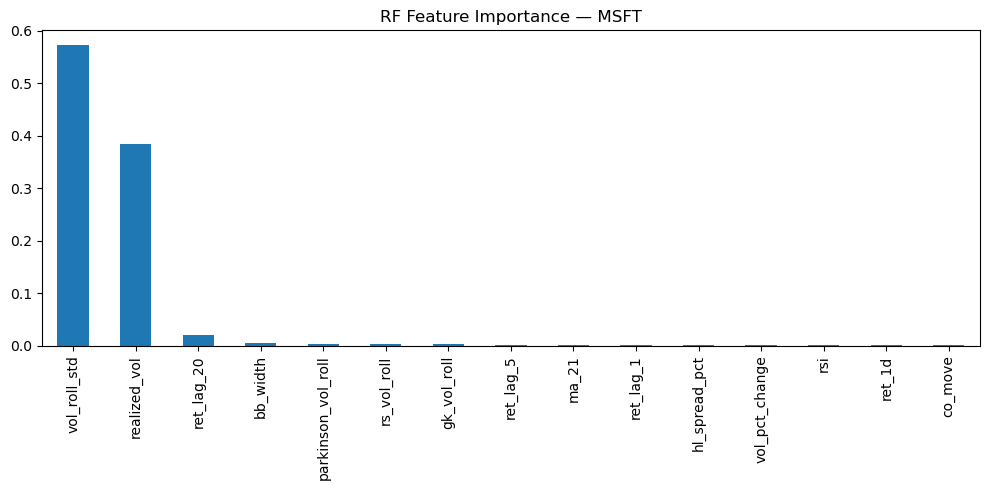

  - rf OK (238 rows)

===== LSTM :: MSFT =====
Train sequences: (921, 30, 16), Test sequences: (208, 30, 16)

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 39: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
[LSTM-Train] MAE=0.001765 | RMSE=0.002397 | MAPE=14.14%
[LSTM-Test] MAE=0.004513 | RMSE=0.005360 | MAPE=52.40%


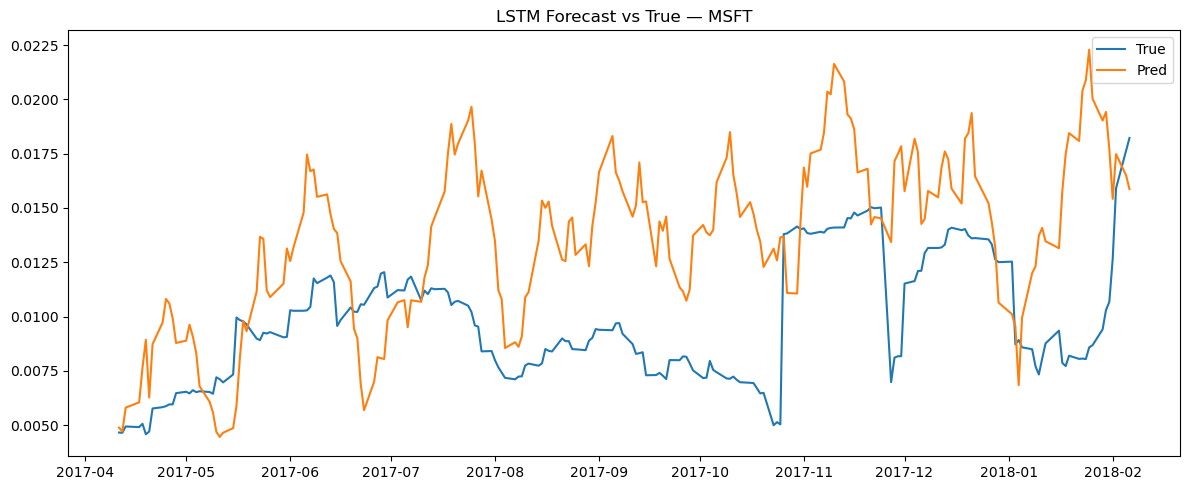

  - lstm OK (208 rows)

===== SVR :: MSFT =====
Best Params: {'C': 1.0, 'epsilon': 0.01, 'gamma': 'auto'}
[SVR-Train] MAE=0.005497 | RMSE=0.005991 | MAPE=48.87%
[SVR-Test] MAE=0.007027 | RMSE=0.007359 | MAPE=90.99%
  - svr OK (238 rows)

===== XGBoost :: MSFT =====
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 600, 'subsample': 0.8}
[XGB-Train] MAE=0.000365 | RMSE=0.000645 | MAPE=2.88%
[XGB-Test] MAE=0.000481 | RMSE=0.000893 | MAPE=5.54%
  - xgb OK (238 rows)
  - rf metrics: MAE=0.000501, RMSE=0.000968, MAPE=5.80%, DirAcc=51.05%
  - lstm metrics: MAE=0.004513, RMSE=0.005360, MAPE=52.40%, DirAcc=45.41%
  - svr metrics: MAE=0.007027, RMSE=0.007359, MAPE=90.99%, DirAcc=49.79%
  - xgb metrics: MAE=0.000481, RMSE=0.000893, MAPE=5.54%, DirAcc=58.65%


In [10]:
# ======= Unified evaluation & merging cell =======
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---------- helper: extract the DataFrame output from a model function ----------
def get_model_out_df(func, ticker, *args, **kwargs):
    """
    Call a model function and return the DataFrame (date, ticker, y_true, y_pred).
    Works with functions that return (model, df) or (model, df, extra).
    Raises informative error if no DataFrame found.
    """
    res = func(ticker, *args, **kwargs)
    # res may be (model, df) or (model, df, extra) or df only
    if isinstance(res, pd.DataFrame):
        df_out = res.copy()
    elif isinstance(res, tuple) or isinstance(res, list):
        df_out = None
        for item in res:
            if isinstance(item, pd.DataFrame):
                df_out = item.copy()
                break
        if df_out is None:
            raise ValueError(f"{func.__name__} did not return a DataFrame as one of its outputs.")
    else:
        raise ValueError(f"Unexpected return type from {func.__name__}: {type(res)}")

    # Standardize column names
    # Accept either 'Name' or 'ticker' for ticker name column
    if 'Name' in df_out.columns and 'ticker' not in df_out.columns:
        df_out = df_out.rename(columns={'Name': 'ticker'})
    if 'date' in df_out.columns:
        df_out['date'] = pd.to_datetime(df_out['date']).dt.normalize()
    # If y_true or y_pred aren't present, try to detect
    if 'y_true' not in df_out.columns or 'y_pred' not in df_out.columns:
        # try common alternatives: 'true', 'actual', 'target' for y_true and 'pred'/'prediction' for y_pred
        colmap = {}
        for c in df_out.columns:
            lc = c.lower()
            if 'true' in lc or 'actual' in lc or 'target' in lc:
                colmap[c] = 'y_true'
            if 'pred' in lc:
                colmap[c] = 'y_pred'
        if colmap:
            df_out = df_out.rename(columns=colmap)
    # Final check
    if not {'date','ticker','y_true','y_pred'}.issubset(df_out.columns):
        missing = {'date','ticker','y_true','y_pred'} - set(df_out.columns)
        raise ValueError(f"Output DataFrame from {func.__name__} missing columns: {missing}. Found: {list(df_out.columns)}")
    # Ensure numeric arrays
    df_out['y_true'] = pd.to_numeric(df_out['y_true'], errors='coerce')
    df_out['y_pred'] = pd.to_numeric(df_out['y_pred'], errors='coerce')

    # Sort by date (safe)
    df_out = df_out.sort_values(['date','ticker']).reset_index(drop=True)
    return df_out[['date','ticker','y_true','y_pred']]

# ---------- helper: compute metrics between two aligned series ----------
def compute_metrics(y_true, y_pred):
    mask = (~np.isnan(y_true)) & (~np.isnan(y_pred))
    if mask.sum() == 0:
        return None
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    # MAPE: ignore points where y_true == 0 by excluding them (to avoid div by zero)
    nonzero_mask = (y_true != 0)
    if nonzero_mask.sum() > 0:
        mape = (np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask]).mean()) * 100
    else:
        mape = np.nan
    # Directional accuracy
    if len(y_true) >= 2:
        true_diff = np.sign(np.diff(y_true))
        pred_diff = np.sign(np.diff(y_pred))
        # Only compare up to min length after diff
        min_len = min(len(true_diff), len(pred_diff))
        if min_len > 0:
            directional_acc = (true_diff[:min_len] == pred_diff[:min_len]).mean() * 100
        else:
            directional_acc = np.nan
    else:
        directional_acc = np.nan

    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE(%)": mape, "DirectionalAcc(%)": directional_acc}

# ---------- main loop: run models, merge outputs, evaluate ----------
def run_all_and_evaluate(tickers, model_funcs):
    """
    tickers: list of tickers to evaluate (e.g., ["AAL","AAPL"])
    model_funcs: dict of name->callable, e.g. {"rf": run_random_forest_for_ticker, ...}
    """
    all_merged = []
    metrics_rows = []

    for t in tickers:
        print(f"\n>>> Processing ticker {t} ...")
        dfs = {}
        # call each model and collect df_out
        for name, func in model_funcs.items():
            try:
                df_out = get_model_out_df(func, t)
                # rename preds to unique names
                df_out = df_out.rename(columns={
                    "y_pred": f"y_pred_{name}",
                    "y_true": f"y_true_{name}"
                })
                dfs[name] = df_out
                print(f"  - {name} OK ({len(df_out)} rows)")
            except Exception as e:
                # safe: continue with other models
                print(f"  - {name} FAILED for {t}: {e}")
                continue

        if not dfs:
            print(f"  No model outputs for {t}, skipping.")
            continue

        # choose base DF to merge on: prefer RF if exists otherwise first model
        base_name = "rf" if "rf" in dfs else list(dfs.keys())[0]
        base_df = dfs[base_name].rename(columns={f"y_true_{base_name}": "y_true"})
        merged = base_df.copy()

        # merge other models (left join to preserve base test timeline)
        for name, dfm in dfs.items():
            if name == base_name:
                continue
            merged = merged.merge(dfm, on=["date","ticker"], how="left")

        # If there are multiple y_true_* cols, consolidate into one 'y_true' by bfill across columns
        y_true_cols = [c for c in merged.columns if c.startswith("y_true_")]
        if y_true_cols:
            merged["y_true"] = merged[["y_true"] + y_true_cols].bfill(axis=1).iloc[:,0]
            # drop extra y_true_ columns
            merged = merged.drop(columns=y_true_cols, errors="ignore")

        # Append merged DF for this ticker
        all_merged.append(merged)

        # Evaluate each model on this ticker using rows where both y_true and y_pred exist
        for name in dfs.keys():
            pred_col = f"y_pred_{name}"
            if pred_col not in merged.columns:
                continue
            metrics = compute_metrics(merged["y_true"].values, merged[pred_col].values)
            if metrics is None:
                print(f"  - {name}: no overlapping predictions to evaluate.")
                continue
            metrics_row = {"ticker": t, "model": name}
            metrics_row.update(metrics)
            metrics_rows.append(metrics_row)
            print(f"  - {name} metrics: MAE={metrics['MAE']:.6f}, RMSE={metrics['RMSE']:.6f}, MAPE={metrics['MAPE(%)']:.2f}%, DirAcc={metrics['DirectionalAcc(%)']:.2f}%")

    # Final concatenated results
    final_merged = pd.concat(all_merged, ignore_index=True) if all_merged else pd.DataFrame()
    metrics_df = pd.DataFrame(metrics_rows)
    return final_merged, metrics_df

# ---------- Example usage ----------
# Map the short names to your actual functions (adjust names if your functions have different names)
model_funcs = {
    "rf": run_random_forest_for_ticker,
    "lstm": run_lstm_for_ticker,
    "svr": run_svr_for_ticker,
    "xgb": run_xgboost_for_ticker
    # optionally add "garch": run_garch_for_ticker if you implemented wrapper
}

# Choose tickers you want to evaluate
tickers = ["AAL", "AAPL", "MSFT"]   # change to your selected tickers

final_results, metrics_df = run_all_and_evaluate(tickers, model_funcs)




In [11]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Rename SVR prediction column for consistency
final_results = final_results.rename(columns={"y_pred": "y_pred_svr"})

# Dictionary to store results
accuracy_results = {}

# Random Forest
mask_rf = final_results["y_pred_rf"].notna()
y_true_rf = final_results.loc[mask_rf, "y_true"]
y_pred_rf = final_results.loc[mask_rf, "y_pred_rf"]
accuracy_results["Random Forest"] = {
    "R2": r2_score(y_true_rf, y_pred_rf),
    "MSE": mean_squared_error(y_true_rf, y_pred_rf),
    "RMSE": np.sqrt(mean_squared_error(y_true_rf, y_pred_rf)),
    "MAE": mean_absolute_error(y_true_rf, y_pred_rf)
}

# LSTM
mask_lstm = final_results["y_pred_lstm"].notna()
y_true_lstm = final_results.loc[mask_lstm, "y_true"]
y_pred_lstm = final_results.loc[mask_lstm, "y_pred_lstm"]
accuracy_results["LSTM"] = {
    "R2": r2_score(y_true_lstm, y_pred_lstm),
    "MSE": mean_squared_error(y_true_lstm, y_pred_lstm),
    "RMSE": np.sqrt(mean_squared_error(y_true_lstm, y_pred_lstm)),
    "MAE": mean_absolute_error(y_true_lstm, y_pred_lstm)
}

# SVR
mask_svr = final_results["y_pred_svr"].notna()
y_true_svr = final_results.loc[mask_svr, "y_true"]
y_pred_svr = final_results.loc[mask_svr, "y_pred_svr"]
accuracy_results["SVR"] = {
    "R2": r2_score(y_true_svr, y_pred_svr),
    "MSE": mean_squared_error(y_true_svr, y_pred_svr),
    "RMSE": np.sqrt(mean_squared_error(y_true_svr, y_pred_svr)),
    "MAE": mean_absolute_error(y_true_svr, y_pred_svr)
}

# Show results
import pandas as pd
results_df = pd.DataFrame(accuracy_results).T
print("\nModel Accuracy Comparison:")
print(results_df)



Model Accuracy Comparison:
                     R2       MSE      RMSE       MAE
Random Forest  0.950585  0.000001  0.001097  0.000676
LSTM           0.411480  0.000013  0.003630  0.002668
SVR           -0.797028  0.000044  0.006614  0.006060


In [12]:
from sklearn.metrics import r2_score

def run_xgboost_for_ticker(ticker, data_dir="data/prepared"):
    print(f"\n===== XGBoost :: {ticker} =====")
    
    # Load prepared features & target
    X, y, meta, feature_cols = load_ticker_frame(ticker, data_dir=data_dir)
    X_train, X_test, y_train, y_test, meta_train, meta_test = ts_train_test_split(X, y, meta, split_ratio=0.8)
    
    # Scale features
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)
    
    # Define model
    xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
    
    # Hyperparameter grid
    param_grid = {
        "n_estimators": [200, 400, 600],
        "max_depth": [4, 6, 8],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    }
    
    # TimeSeriesSplit for CV
    tscv = TimeSeriesSplit(n_splits=5)
    gs = GridSearchCV(xgb, param_grid, scoring="neg_mean_absolute_error", cv=tscv, n_jobs=-1, verbose=0)
    gs.fit(X_train_s, y_train)
    print("Best Params:", gs.best_params_)
    
    # Best model
    best_xgb = gs.best_estimator_
    pred_train = best_xgb.predict(X_train_s)
    pred_test  = best_xgb.predict(X_test_s)
    
    # Evaluate
    eval_regression(y_train, pred_train, label="XGB-Train")
    eval_regression(y_test,  pred_test,  label="XGB-Test")
    
    # 🔹 Additional Metrics: R²
    r2_train = r2_score(y_train, pred_train)
    r2_test  = r2_score(y_test, pred_test)
    print(f"[XGB-Train] R² = {r2_train:.4f}")
    print(f"[XGB-Test]  R² = {r2_test:.4f}")
    
    # 🔹 Directional Accuracy
    dir_acc = (np.sign(pred_test[1:] - pred_test[:-1]) == np.sign(y_test.values[1:] - y_test.values[:-1])).mean() * 100
    print(f"[XGB-Test] Directional Accuracy = {dir_acc:.2f}%")
    
    # Collect results
    out = pd.DataFrame({
        "date": meta_test["date"].values,
        "ticker": meta_test["Name"].values,
        "y_true": y_test.values,
        "y_pred": pred_test
    })
    
    return best_xgb, out


In [13]:
xgb_model, xgb_out = run_xgboost_for_ticker("AAL")



===== XGBoost :: AAL =====
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 600, 'subsample': 1.0}
[XGB-Train] MAE=0.000495 | RMSE=0.000802 | MAPE=2.37%
[XGB-Test] MAE=0.001224 | RMSE=0.001887 | MAPE=8.20%
[XGB-Train] R² = 0.9840
[XGB-Test]  R² = 0.7526
[XGB-Test] Directional Accuracy = 57.81%


## Phase 5

In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def _metrics(y_true, y_pred):
    """Return MAE, RMSE, MAPE, Directional Accuracy for aligned arrays."""
    mask = (~np.isnan(y_true)) & (~np.isnan(y_pred))
    y_t = y_true[mask]
    y_p = y_pred[mask]
    if len(y_t) == 0:
        return {"MAE": np.nan, "RMSE": np.nan, "MAPE(%)": np.nan, "DirAcc(%)": np.nan}
    mae = mean_absolute_error(y_t, y_p)
    rmse = np.sqrt(mean_squared_error(y_t, y_p))
    nz = y_t != 0
    mape = np.mean(np.abs((y_t[nz] - y_p[nz]) / y_t[nz])) * 100 if nz.sum() > 0 else np.nan
    if len(y_t) >= 2:
        td = np.sign(np.diff(y_t))
        pdiff = np.sign(np.diff(y_p))
        m = min(len(td), len(pdiff))
        diracc = (td[:m] == pdiff[:m]).mean() * 100
    else:
        diracc = np.nan
    return {"MAE": mae, "RMSE": rmse, "MAPE(%)": mape, "DirAcc(%)": diracc}

def build_model_columns(df):
    """
    Detect model prediction columns in a final_results-like frame.
    Expected: 'y_true' plus one or more of:
      'y_pred_rf','y_pred_lstm','y_pred_svr','y_pred_xgb','y_pred_garch'
    Returns dict name->column.
    """
    candidates = {
        "RF": "y_pred_rf",
        "LSTM": "y_pred_lstm",
        "SVR": "y_pred_svr",   # ensure you renamed 'y_pred' -> 'y_pred_svr'
        "XGB": "y_pred_xgb",
        "GARCH": "y_pred_garch"
    }
    available = {k:v for k,v in candidates.items() if v in df.columns}
    if not available:
        raise ValueError("No prediction columns found. Make sure to rename e.g. SVR -> 'y_pred_svr'.")
    return available


In [15]:
from scipy import stats

def diebold_mariano(y_true, yhat_1, yhat_2, h=1, power=2):
    """
    Diebold–Mariano test for equal predictive accuracy.
    y_true, yhat_* must be aligned 1-D arrays (we align inside).
    h: forecast horizon (1 for 1-step ahead)
    power: 1 for absolute loss, 2 for squared loss (default).
    Returns dict with DM stat and p-value (two-sided).
    """
    # Align series
    df = pd.DataFrame({"y": y_true, "m1": yhat_1, "m2": yhat_2}).dropna()
    if len(df) < 5:
        return {"DM": np.nan, "pval": np.nan, "N": len(df)}
    e1 = df["y"] - df["m1"]
    e2 = df["y"] - df["m2"]
    if power == 1:
        d = np.abs(e1) - np.abs(e2)
    else:
        d = e1**2 - e2**2
    d = d.values
    T = len(d)

    # Newey–West estimator for var(d) with lag = h-1
    lag = max(h-1, 0)
    dbar = d.mean()
    # autocovariance
    gamma0 = np.var(d, ddof=1)
    nw_var = gamma0
    for j in range(1, lag+1):
        gammaj = np.sum((d[j:] - dbar) * (d[:-j] - dbar)) / (T - 1)
        w = 1 - j/(lag+1)
        nw_var += 2 * w * gammaj
    dm_stat = dbar / np.sqrt(nw_var / T) if nw_var > 0 else np.nan
    # asymptotically N(0,1); small-sample often uses t_{T-1}
    pval = 2 * (1 - stats.t.cdf(np.abs(dm_stat), df=T-1))
    return {"DM": dm_stat, "pval": pval, "N": T}

def dm_table(df, base="RF", compare_with=("GARCH","LSTM","SVR","XGB")):
    models = build_model_columns(df)
    rows = []
    if base not in models:
        raise ValueError(f"Base model '{base}' not found among {list(models.keys())}")
    for other in compare_with:
        if other not in models:
            continue
        res = diebold_mariano(
            df["y_true"].values, 
            df[models[base]].values, 
            df[models[other]].values, 
            h=1, power=2
        )
        rows.append({"Base": base, "Other": other, **res})
    return pd.DataFrame(rows)


In [16]:
# If final_results contains multiple tickers, do per ticker
dm_results = []
for tkr, g in final_results.groupby("ticker"):
    dmt = dm_table(g, base="RF", compare_with=("GARCH","LSTM","SVR","XGB"))
    dmt.insert(0, "ticker", tkr)
    dm_results.append(dmt)
dm_results = pd.concat(dm_results, ignore_index=True)
print(dm_results)


  ticker Base Other         DM          pval    N
0    AAL   RF  LSTM  -6.438926  8.248007e-10  208
1    AAL   RF   SVR -14.977896  0.000000e+00  238
2    AAL   RF   XGB  -3.164335  1.757811e-03  238
3   AAPL   RF  LSTM  -7.665160  6.812328e-13  208
4   AAPL   RF   SVR -23.688652  0.000000e+00  238
5   AAPL   RF   XGB  -1.334301  1.833858e-01  238
6   MSFT   RF  LSTM -11.917580  0.000000e+00  208
7   MSFT   RF   SVR -28.349742  0.000000e+00  238
8   MSFT   RF   XGB   1.998410  4.681482e-02  238


In [17]:
def forecast_loss_ir(df, pred_col, freq=252):
    """
    Information Ratio (Sharpe-like) of negative squared error series.
    Returns mean, std, IR_annualized.
    """
    e = df["y_true"] - df[pred_col]
    loss = -(e**2)             # we "reward" small errors => larger values are better
    mu = loss.mean()
    sd = loss.std(ddof=1)
    ir = (mu / sd) * np.sqrt(freq) if sd > 0 else np.nan
    return {"LossMean": mu, "LossStd": sd, "IR_annual": ir}

def forecast_loss_ir_table(df):
    models = build_model_columns(df)
    rows = []
    for name, col in models.items():
        sub = df[["y_true", col]].dropna()
        if len(sub) < 5: 
            continue
        rows.append({"Model": name, **forecast_loss_ir(sub, col)})
    return pd.DataFrame(rows).sort_values("IR_annual", ascending=False)

# Example per ticker:
ir_tables = []
for tkr, g in final_results.groupby("ticker"):
    irt = forecast_loss_ir_table(g)
    irt.insert(0, "ticker", tkr)
    ir_tables.append(irt)
ir_tables = pd.concat(ir_tables, ignore_index=True)
print(ir_tables)


   ticker Model      LossMean   LossStd  IR_annual
0     AAL   XGB -3.560238e-06  0.000011  -5.183256
1     AAL    RF -1.471095e-06  0.000003  -7.139510
2     AAL  LSTM -4.876994e-06  0.000008 -10.036484
3     AAL   SVR -3.400978e-05  0.000034 -15.779828
4    AAPL    RF -1.201604e-06  0.000005  -3.923379
5    AAPL   XGB -1.405044e-06  0.000005  -4.514527
6    AAPL  LSTM -5.920326e-06  0.000010  -9.304488
7    AAPL   SVR -4.309137e-05  0.000027 -25.274407
8    MSFT   XGB -7.977871e-07  0.000005  -2.493181
9    MSFT    RF -9.364518e-07  0.000006  -2.607445
10   MSFT  LSTM -2.873276e-05  0.000033 -13.960807
11   MSFT   SVR -5.414821e-05  0.000028 -30.501881


In [18]:
def forecast_loss_ir(df, pred_col, freq=252):
    """
    Information Ratio (Sharpe-like) of negative squared error series.
    Returns mean, std, IR_annualized.
    """
    e = df["y_true"] - df[pred_col]
    loss = -(e**2)             # we "reward" small errors => larger values are better
    mu = loss.mean()
    sd = loss.std(ddof=1)
    ir = (mu / sd) * np.sqrt(freq) if sd > 0 else np.nan
    return {"LossMean": mu, "LossStd": sd, "IR_annual": ir}

def forecast_loss_ir_table(df):
    models = build_model_columns(df)
    rows = []
    for name, col in models.items():
        sub = df[["y_true", col]].dropna()
        if len(sub) < 5: 
            continue
        rows.append({"Model": name, **forecast_loss_ir(sub, col)})
    return pd.DataFrame(rows).sort_values("IR_annual", ascending=False)

# Example per ticker:
ir_tables = []
for tkr, g in final_results.groupby("ticker"):
    irt = forecast_loss_ir_table(g)
    irt.insert(0, "ticker", tkr)
    ir_tables.append(irt)
ir_tables = pd.concat(ir_tables, ignore_index=True)
print(ir_tables)


   ticker Model      LossMean   LossStd  IR_annual
0     AAL   XGB -3.560238e-06  0.000011  -5.183256
1     AAL    RF -1.471095e-06  0.000003  -7.139510
2     AAL  LSTM -4.876994e-06  0.000008 -10.036484
3     AAL   SVR -3.400978e-05  0.000034 -15.779828
4    AAPL    RF -1.201604e-06  0.000005  -3.923379
5    AAPL   XGB -1.405044e-06  0.000005  -4.514527
6    AAPL  LSTM -5.920326e-06  0.000010  -9.304488
7    AAPL   SVR -4.309137e-05  0.000027 -25.274407
8    MSFT   XGB -7.977871e-07  0.000005  -2.493181
9    MSFT    RF -9.364518e-07  0.000006  -2.607445
10   MSFT  LSTM -2.873276e-05  0.000033 -13.960807
11   MSFT   SVR -5.414821e-05  0.000028 -30.501881


In [19]:
def metrics_by_model(df):
    models = build_model_columns(df)
    rows = []
    for name, col in models.items():
        m = _metrics(df["y_true"].values, df[col].values)
        rows.append({"Model": name, **m})
    return pd.DataFrame(rows).sort_values("MAE")

# Per ticker
metrics_list = []
for tkr, g in final_results.groupby("ticker"):
    mt = metrics_by_model(g)
    mt.insert(0, "ticker", tkr)
    metrics_list.append(mt)
metrics_df = pd.concat(metrics_list, ignore_index=True)
print("Per-ticker metrics:")
print(metrics_df)

# Overall (all tickers combined)
overall_metrics = metrics_by_model(final_results)
print("\nOverall metrics across all tickers:")
print(overall_metrics)



Per-ticker metrics:
   ticker Model       MAE      RMSE    MAPE(%)  DirAcc(%)
0     AAL    RF  0.000855  0.001213   5.372782  56.962025
1     AAL   XGB  0.001224  0.001887   8.198704  57.805907
2     AAL  LSTM  0.001679  0.002208  10.128043  49.758454
3     AAL   SVR  0.005045  0.005832  33.405633  48.523207
4    AAPL    RF  0.000674  0.001096   6.912612  54.852321
5    AAPL   XGB  0.000698  0.001185   7.855274  59.493671
6    AAPL  LSTM  0.001813  0.002433  15.288264  50.241546
7    AAPL   SVR  0.006108  0.006564  67.042764  50.632911
8    MSFT   XGB  0.000481  0.000893   5.537636  58.649789
9    MSFT    RF  0.000501  0.000968   5.802785  51.054852
10   MSFT  LSTM  0.004513  0.005360  52.399397  45.410628
11   MSFT   SVR  0.007027  0.007359  90.994078  49.789030

Overall metrics across all tickers:
  Model       MAE      RMSE    MAPE(%)  DirAcc(%)
0    RF  0.000676  0.001097   6.029393  54.417952
3   XGB  0.000801  0.001386   7.197205  58.765778
1  LSTM  0.002668  0.003630  25.938568 

In [20]:
def regime_eval(df, q_low=0.33, q_high=0.67):
    # define regimes using y_true quantiles
    lo = df["y_true"].quantile(q_low)
    hi = df["y_true"].quantile(q_high)
    def regime(y):
        if y <= lo: return "LowVol"
        if y >= hi: return "HighVol"
        return "MidVol"
    tmp = df.copy()
    tmp["regime"] = tmp["y_true"].apply(regime)

    models = build_model_columns(tmp)
    rows = []
    for reg, g in tmp.groupby("regime"):
        for name, col in models.items():
            m = _metrics(g["y_true"].values, g[col].values)
            rows.append({"Regime": reg, "Model": name, **m})
    return pd.DataFrame(rows).sort_values(["Regime","MAE"])

# Per ticker
regime_all = []
for tkr, g in final_results.groupby("ticker"):
    rt = regime_eval(g)
    rt.insert(0, "ticker", tkr)
    regime_all.append(rt)
regime_all = pd.concat(regime_all, ignore_index=True)
print(regime_all)


   ticker   Regime Model       MAE      RMSE     MAPE(%)  DirAcc(%)
0     AAL  HighVol   XGB  0.000736  0.001173    3.373923  65.384615
1     AAL  HighVol    RF  0.000793  0.001238    3.642576  56.410256
2     AAL  HighVol  LSTM  0.001792  0.002177    8.094633  45.588235
3     AAL  HighVol   SVR  0.002511  0.003077   11.812058  43.589744
4     AAL   LowVol    RF  0.001063  0.001418    8.385170  55.128205
5     AAL   LowVol  LSTM  0.001513  0.002229   11.982874  45.333333
6     AAL   LowVol   XGB  0.002027  0.002709   15.871985  53.846154
7     AAL   LowVol   SVR  0.007857  0.008107   60.508828  52.564103
8     AAL   MidVol    RF  0.000710  0.000937    4.106627  62.025316
9     AAL   MidVol   XGB  0.000913  0.001410    5.385810  62.025316
10    AAL   MidVol  LSTM  0.001755  0.002218   10.117536  56.451613
11    AAL   MidVol   SVR  0.004772  0.005190   27.964883  56.962025
12   AAPL  HighVol   XGB  0.000517  0.001168    3.510338  56.410256
13   AAPL  HighVol    RF  0.000617  0.001222    

In [21]:
def rolling_mae(df, window=60):
    models = build_model_columns(df)
    out = []
    g = df.sort_values("date").copy()
    for name, col in models.items():
        # compute rolling MAE on overlapping windows where both y_true & pred exist
        err = np.abs(g["y_true"] - g[col])
        rmae = err.rolling(window, min_periods=window//2).mean()
        out.append(pd.DataFrame({"date": g["date"], "Model": name, "RollingMAE": rmae}))
    return pd.concat(out, ignore_index=True)

# Per ticker example
rolling_all = []
for tkr, g in final_results.groupby("ticker"):
    r = rolling_mae(g, window=60)
    r.insert(0, "ticker", tkr)
    rolling_all.append(r)
rolling_all = pd.concat(rolling_all, ignore_index=True)
print(rolling_all.head())


  ticker       date Model  RollingMAE
0    AAL 2017-02-28    RF         NaN
1    AAL 2017-03-01    RF         NaN
2    AAL 2017-03-02    RF         NaN
3    AAL 2017-03-03    RF         NaN
4    AAL 2017-03-06    RF         NaN


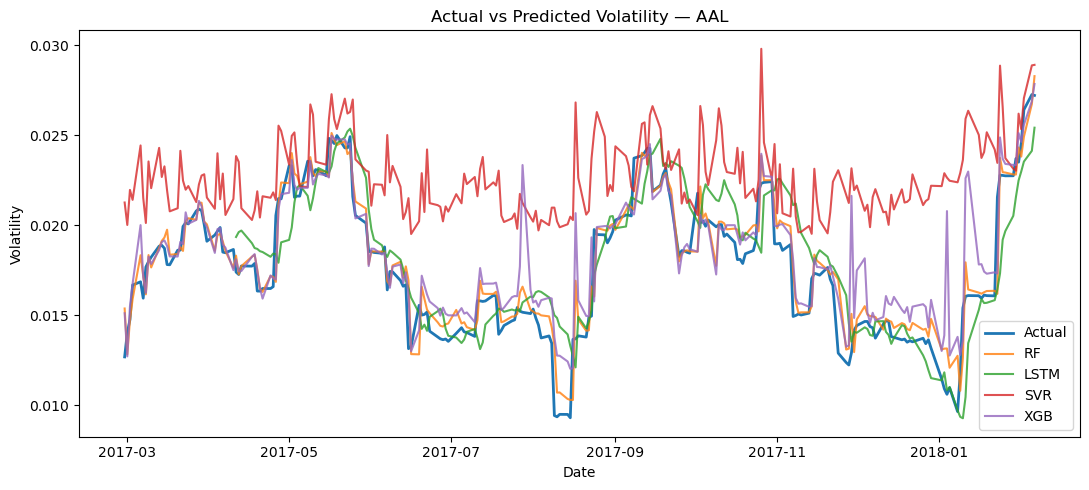

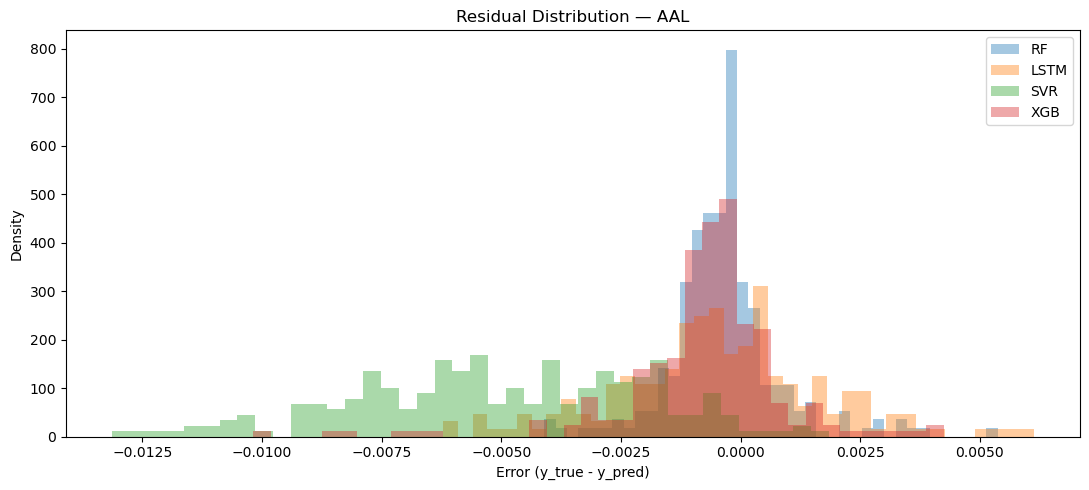

<Figure size 800x500 with 0 Axes>

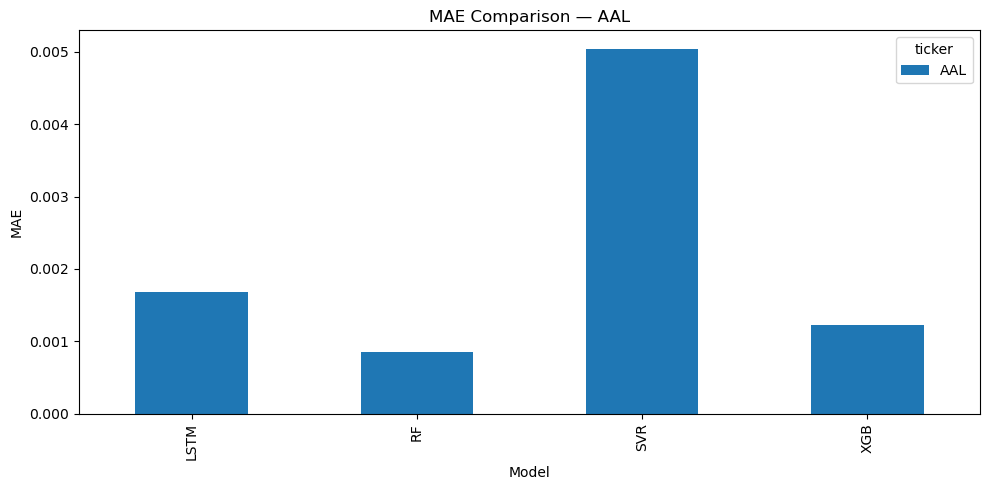

In [22]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(df, ticker=None, max_points=None):
    models = build_model_columns(df)
    g = df.sort_values("date")
    if ticker is not None and "ticker" in g.columns:
        g = g[g["ticker"] == ticker]
    if max_points:
        g = g.tail(max_points)

    plt.figure(figsize=(11,5))
    plt.plot(g["date"], g["y_true"], label="Actual", linewidth=2)
    for name, col in models.items():
        plt.plot(g["date"], g[col], label=name, alpha=0.8)
    title = f"Actual vs Predicted Volatility{f' — {ticker}' if ticker else ''}"
    plt.title(title)
    plt.xlabel("Date"); plt.ylabel("Volatility")
    plt.legend(); plt.tight_layout(); plt.show()

def plot_residual_hist(df, ticker=None, bins=40):
    models = build_model_columns(df)
    g = df if ticker is None else df[df["ticker"]==ticker]
    plt.figure(figsize=(11,5))
    for name, col in models.items():
        err = (g["y_true"] - g[col]).dropna()
        plt.hist(err, bins=bins, alpha=0.4, label=name, density=True)
    plt.title(f"Residual Distribution{f' — {ticker}' if ticker else ''}")
    plt.xlabel("Error (y_true - y_pred)"); plt.ylabel("Density")
    plt.legend(); plt.tight_layout(); plt.show()

def plot_metric_bars(metrics_df, metric="MAE", ticker=None):
    d = metrics_df if ticker is None else metrics_df[metrics_df["ticker"]==ticker]
    pivot = d.pivot(index="Model", columns="ticker", values=metric) if "ticker" in d.columns else d.set_index("Model")[[metric]]
    plt.figure(figsize=(8,5))
    pivot.plot(kind="bar", figsize=(10,5))
    plt.title(f"{metric} Comparison{'' if ticker is None else ' — ' + ticker}")
    plt.ylabel(metric); plt.xlabel("Model")
    plt.tight_layout(); plt.show()

# Examples:
plot_actual_vs_pred(final_results, ticker="AAL", max_points=300)
plot_residual_hist(final_results, ticker="AAL")
plot_metric_bars(metrics_df, metric="MAE", ticker="AAL")



===== Random Forest :: AAL =====
Best Params: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 600}
[RF-Train] MAE=0.000502 | RMSE=0.000948 | MAPE=2.37%
[RF-Test] MAE=0.000855 | RMSE=0.001213 | MAPE=5.37%

Top Feature Importances:
vol_roll_std          0.905275
realized_vol          0.056978
ret_lag_20            0.015561
ma_21                 0.004086
hl_spread_pct         0.003743
ret_lag_5             0.002647
rsi                   0.002343
bb_width              0.001826
vol_pct_change        0.001483
ret_lag_1             0.001261
parkinson_vol_roll    0.001143
rs_vol_roll           0.001060
gk_vol_roll           0.000924
ret_1d                0.000891
co_move               0.000764
dtype: float64


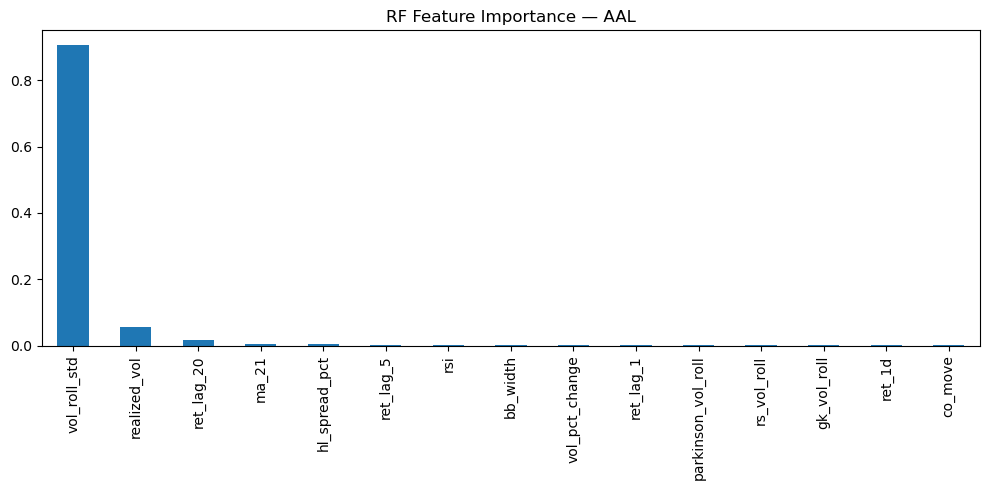

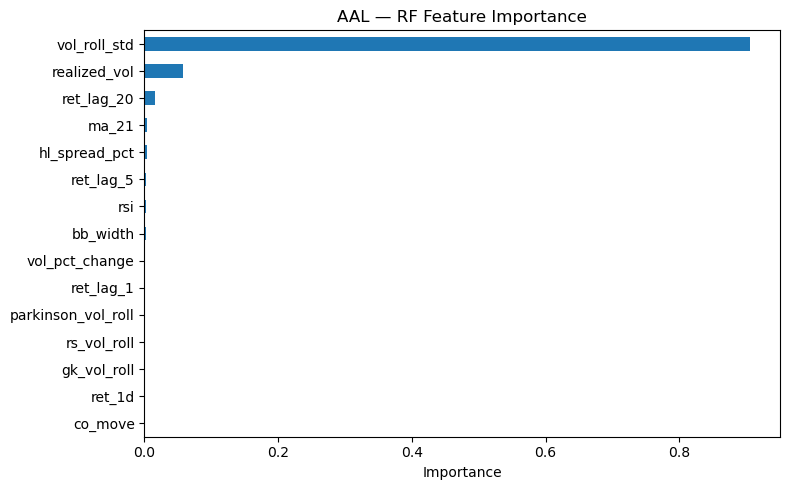

In [23]:
def plot_rf_importances(importance_series, top_n=15, title="RF Feature Importance"):
    imp = importance_series.sort_values(ascending=False).head(top_n)
    plt.figure(figsize=(8,5))
    imp[::-1].plot(kind="barh")
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout(); plt.show()

# Example after training RF:
rf_model, rf_out, rf_imp = run_random_forest_for_ticker("AAL")
plot_rf_importances(rf_imp, top_n=15, title="AAL — RF Feature Importance")


## Phase 6

In [24]:
# Cell 6A
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os, gc, math, warnings
warnings.filterwarnings("ignore")

# helper to compute metrics
def mae_rmse_mape(y_true, y_pred):
    mask = (~np.isnan(y_true)) & (~np.isnan(y_pred))
    if mask.sum() == 0:
        return {"MAE": np.nan, "RMSE": np.nan, "MAPE(%)": np.nan}
    y_t = y_true[mask]; y_p = y_pred[mask]
    mae = mean_absolute_error(y_t, y_p)
    rmse = math.sqrt(mean_squared_error(y_t, y_p))
    nonzero = y_t != 0
    mape = (np.abs((y_t[nonzero] - y_p[nonzero]) / y_t[nonzero]).mean() * 100) if nonzero.sum()>0 else np.nan
    return {"MAE": mae, "RMSE": rmse, "MAPE(%)": mape}


In [25]:
# Cell 6B: regime definitions
def compute_price_trend_regime(df, window=63):
    """
    Determine bull/bear using rolling return over `window` days (approx 3 months if daily ~63 trading days).
    Returns the df with 'trend_regime' column: 'Bull' if rolling return >0 else 'Bear'.
    """
    d = df.copy().sort_values("date").reset_index(drop=True)
    d['roll_ret'] = d['close'].pct_change(periods=window)
    d['trend_regime'] = np.where(d['roll_ret'] > 0, "Bull", "Bear")
    return d

def compute_volatility_regime(df, low_q=0.33, high_q=0.67, vol_col='realized_vol_21'):
    """
    Label 'LowVol', 'MidVol', 'HighVol' by quantiles of realized volatility column.
    """
    d = df.copy().sort_values("date").reset_index(drop=True)
    lo = d[vol_col].quantile(low_q)
    hi = d[vol_col].quantile(high_q)
    def label(v):
        if np.isnan(v): return np.nan
        if v <= lo: return "LowVol"
        if v >= hi: return "HighVol"
        return "MidVol"
    d['vol_regime'] = d[vol_col].apply(label)
    return d


In [26]:
import numpy as np

# Helper function
def add_realized_volatility(df, vol_col="realized_vol_21", window=21):
    df["log_ret"] = np.log(df["close"] / df["close"].shift(1))
    df[vol_col] = df["log_ret"].rolling(window).std() * np.sqrt(252)  # annualized
    return df

# Load prepared data
df_aal = pd.read_csv("data/prepared/AAL_prepared.csv", parse_dates=['date'])

# Step 1: Add trend regime
df_aal = compute_price_trend_regime(df_aal, window=63)

# Step 2: Compute realized volatility
df_aal = add_realized_volatility(df_aal)

# Step 3: Compute volatility regime (Low/Mid/High)
df_aal = compute_volatility_regime(df_aal, low_q=0.33, high_q=0.67, vol_col="realized_vol_21")

# Inspect results
print(df_aal[["date","close","roll_ret","trend_regime","realized_vol_21","vol_regime"]].tail())


           date  close  roll_ret trend_regime  realized_vol_21 vol_regime
1204 2018-02-01  53.88  0.150790         Bull         0.373164    HighVol
1205 2018-02-02  52.10  0.089047         Bull         0.389494    HighVol
1206 2018-02-05  49.76  0.050676         Bull         0.419393    HighVol
1207 2018-02-06  51.18  0.078609         Bull         0.432806    HighVol
1208 2018-02-07  51.40  0.081877         Bull         0.432057    HighVol


In [27]:
# Cell 6C
def performance_by_trend(final_results, prepared_dir="data/prepared", window=63):
    rows = []
    for tkr, g in final_results.groupby("ticker"):
        # load price file
        p = pd.read_csv(os.path.join(prepared_dir, f"{tkr}_prepared.csv"), parse_dates=['date'])
        p = compute_price_trend_regime(p, window=window)[['date','trend_regime']]
        merged = g.merge(p, on='date', how='left')  # align regimes to predictions
        # for each model column found:
        preds = [c for c in merged.columns if c.startswith("y_pred")]
        for model_col in preds:
            for regime, sub in merged.groupby('trend_regime'):
                if sub.shape[0] < 5: continue
                m = mae_rmse_mape(sub['y_true'].values, sub[model_col].values)
                rows.append({"ticker": tkr, "model": model_col, "trend_regime": regime, **m})
    return pd.DataFrame(rows)

trend_perf = performance_by_trend(final_results)
trend_perf_pivot = trend_perf.pivot_table(index=['ticker','trend_regime'], columns='model', values='MAE')
print(trend_perf.head())


  ticker        model trend_regime       MAE      RMSE    MAPE(%)
0    AAL    y_pred_rf         Bear  0.000743  0.001080   3.948299
1    AAL    y_pred_rf         Bull  0.000949  0.001315   6.576415
2    AAL  y_pred_lstm         Bear  0.001990  0.002451  10.617126
3    AAL  y_pred_lstm         Bull  0.001480  0.002039   9.816108
4    AAL   y_pred_svr         Bear  0.003562  0.004103  19.612421


In [28]:
# --- Add realized volatility + regimes to final_results ---
def add_realized_volatility(df, vol_col="realized_vol_21", window=21):
    df = df.copy()
    df["log_ret"] = np.log(df["close"] / df["close"].shift(1))
    df[vol_col] = df["log_ret"].rolling(window).std() * np.sqrt(252)
    return df

def attach_volatility_regimes(final_results, tickers, data_dir="data/prepared"):
    enriched = []
    for t in tickers:
        # Load prepared OHLC data
        df = pd.read_csv(f"{data_dir}/{t}_prepared.csv", parse_dates=["date"])
        df = add_realized_volatility(df)
        df = compute_volatility_regime(df, low_q=0.33, high_q=0.67, vol_col="realized_vol_21")
        # Keep only date + regime info
        df = df[["date", "realized_vol_21", "vol_regime"]]
        df["ticker"] = t
        # Merge with predictions
        merged = final_results[final_results["ticker"] == t].merge(df, on=["date","ticker"], how="left")
        enriched.append(merged)
    return pd.concat(enriched, ignore_index=True)

# Update final_results
final_results = attach_volatility_regimes(final_results, tickers)
print(final_results.head())


        date ticker    y_true  y_pred_rf  y_pred_lstm  y_pred_svr  y_pred_xgb  \
0 2017-02-28    AAL  0.012687   0.015377          NaN    0.021266    0.015112   
1 2017-03-01    AAL  0.014028   0.012829          NaN    0.020019    0.012717   
2 2017-03-02    AAL  0.014755   0.014730          NaN    0.021965    0.015500   
3 2017-03-03    AAL  0.016680   0.015898          NaN    0.021413    0.016752   
4 2017-03-06    AAL  0.016860   0.018336          NaN    0.024437    0.020009   

   realized_vol_21 vol_regime  
0         0.252720     LowVol  
1         0.201405     LowVol  
2         0.222684     LowVol  
3         0.234224     LowVol  
4         0.264792     LowVol  


In [30]:
print(final_results.columns.tolist())


['date', 'ticker', 'y_true', 'y_pred_rf', 'y_pred_lstm', 'y_pred_svr', 'y_pred_xgb', 'realized_vol_21', 'vol_regime']


In [32]:
# Cell 6E - Fixed
def extreme_event_eval(df, q=0.95):
    """
    Evaluate model performance during extreme volatility events.
    Extreme events = top q quantile of realized_vol_21 per ticker.
    """
    rows = []
    for tkr, g in df.groupby("ticker"):
        if "realized_vol_21" not in g.columns:
            continue

        # Threshold for extreme volatility
        thr = g["realized_vol_21"].quantile(q)

        # Select extreme events
        extreme = g[g["realized_vol_21"] >= thr]

        if extreme.empty:
            continue

        # Loop through models
        preds = [c for c in extreme.columns if c.startswith("y_pred")]
        for model_col in preds:
            if extreme.shape[0] < 3:
                continue
            m = mae_rmse_mape(extreme["y_true"].values, extreme[model_col].values)
            rows.append({
                "ticker": tkr,
                "model": model_col.replace("y_pred_", "").upper(),
                "n_events": extreme.shape[0],
                **m
            })
    return pd.DataFrame(rows)

# Run evaluation
extreme_eval = extreme_event_eval(final_results)
print(extreme_eval)


   ticker model  n_events       MAE      RMSE    MAPE(%)
0     AAL    RF        12  0.000589  0.000710   2.348746
1     AAL  LSTM        12  0.001489  0.001847   6.073317
2     AAL   SVR        12  0.002187  0.002620   9.235772
3     AAL   XGB        12  0.000424  0.000472   1.727058
4    AAPL    RF        12  0.000515  0.000973   3.395721
5    AAPL  LSTM        12  0.002828  0.002973  14.910047
6    AAPL   SVR        12  0.001419  0.001892   8.605663
7    AAPL   XGB        12  0.000369  0.000493   1.981689
8    MSFT    RF        12  0.000839  0.001896   9.487716
9    MSFT  LSTM        12  0.002426  0.003110  20.210904
10   MSFT   SVR        12  0.002862  0.003848  26.261646
11   MSFT   XGB        12  0.000860  0.001573   8.831187


In [34]:
# Cell 6F - Fixed
def summarize_when_model_beats(final_results):
    """
    For each ticker and volatility regime, find the model with the lowest MAE.
    """
    beat_rows = []
    preds = [c for c in final_results.columns if c.startswith("y_pred")]

    # Loop over ticker + vol_regime
    for (tkr, regime), group in final_results.groupby(["ticker", "vol_regime"]):
        if group.empty:
            continue

        model_metrics = []
        for model_col in preds:
            m = mae_rmse_mape(group["y_true"].values, group[model_col].values)
            model_metrics.append({
                "model": model_col.replace("y_pred_", "").upper(),
                "MAE": m["MAE"]
            })

        if len(model_metrics) == 0:
            continue

        # Select best (lowest MAE)
        best = min(model_metrics, key=lambda x: x["MAE"])
        beat_rows.append({
            "ticker": tkr,
            "regime": regime,
            "best_model": best["model"],
            "best_mae": best["MAE"]
        })

    return pd.DataFrame(beat_rows)

# Run
best_by_regime = summarize_when_model_beats(final_results)
print(best_by_regime)


  ticker   regime best_model  best_mae
0    AAL  HighVol        XGB  0.000491
1    AAL   LowVol         RF  0.000955
2    AAL   MidVol        XGB  0.000734
3   AAPL  HighVol        XGB  0.000381
4   AAPL   LowVol         RF  0.000773
5   AAPL   MidVol        XGB  0.000382
6   MSFT  HighVol        XGB  0.000574
7   MSFT   LowVol        XGB  0.000460
8   MSFT   MidVol        XGB  0.000506


In [ ]:
# Cell 6G
def stability_across_stocks(final_results):
    """
    Count how often each model is the best performer across tickers and regimes.
    """
    preds = [c for c in final_results.columns if c.startswith("y_pred")]
    rows = []

    for (tkr, regime), group in final_results.groupby(["ticker", "vol_regime"]):
        if group.empty:
            continue

        # Compare models
        best_model = None
        best_mae = float("inf")
        for model_col in preds:
            m = mae_rmse_mape(group["y_true"].values, group[model_col].values)
            if m["MAE"] < best_mae:
                best_mae = m["MAE"]
                best_model = model_col.replace("y_pred_", "").upper()

        if best_model:
            rows.append({"ticker": tkr, "regime": regime, "best_model": best_model})

    df = pd.DataFrame(rows)
    return df["best_model"].value_counts().reset_index().rename(
        columns={"index": "model", "best_model": "count"}
    )

# Run
stability_summary = stability_across_stocks(final_results)
print(stability_summary)


   count  count
0    XGB      7
1     RF      2


In [36]:
# Cell 6H
def sensitivity_by_regime(final_results):
    """
    Compare model performance across volatility regimes (High, Mid, Low).
    """
    preds = [c for c in final_results.columns if c.startswith("y_pred")]
    rows = []

    for regime, group in final_results.groupby("vol_regime"):
        for model_col in preds:
            m = mae_rmse_mape(group["y_true"].values, group[model_col].values)
            rows.append({
                "vol_regime": regime,
                "model": model_col.replace("y_pred_", "").upper(),
                **m
            })

    return pd.DataFrame(rows)

# Run
sensitivity_table = sensitivity_by_regime(final_results)
print(sensitivity_table.head())


  vol_regime model       MAE      RMSE    MAPE(%)
0    HighVol    RF  0.000554  0.001014   3.718352
1    HighVol  LSTM  0.002514  0.003128  15.053688
2    HighVol   SVR  0.002099  0.002650  13.345732
3    HighVol   XGB  0.000479  0.000828   3.084700
4     LowVol    RF  0.000728  0.001176   7.118680


In [37]:
# Cell 6I
def rolling_window_eval(final_results, window=63):
    """
    Compute rolling MAE for each model across time.
    """
    preds = [c for c in final_results.columns if c.startswith("y_pred")]
    rows = []

    for tkr, g in final_results.groupby("ticker"):
        g = g.sort_values("date")
        for model_col in preds:
            roll = (
                g.apply(lambda row: abs(row["y_true"] - row[model_col]), axis=1)
                  .rolling(window).mean()
            )
            tmp = pd.DataFrame({
                "date": g["date"],
                "ticker": tkr,
                "model": model_col.replace("y_pred_", "").upper(),
                f"rolling_mae_{window}": roll
            })
            rows.append(tmp)

    return pd.concat(rows, ignore_index=True)

# Run
rolling_eval = rolling_window_eval(final_results)
print(rolling_eval.head())


        date ticker model  rolling_mae_63
0 2017-02-28    AAL    RF             NaN
1 2017-03-01    AAL    RF             NaN
2 2017-03-02    AAL    RF             NaN
3 2017-03-03    AAL    RF             NaN
4 2017-03-06    AAL    RF             NaN
